In [1]:
from IPython.display import clear_output
#from ipywidgets import interact, IntSlider

import os, os.path, shutil
import zipfile
import random
import json
import pickle
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import torch
import pypianoroll
import pretty_midi
import music21
from music21 import *
from pypianoroll import Multitrack, Track
from tqdm import tqdm
from livelossplot import PlotLosses
from livelossplot.outputs import MatplotlibPlot
import sys
#configure.run()

#temp = pathlib.PosixPath
#pathlib.PosixPath = pathlib.WindowsPath
#music21.environment.set('musescoreDirectPNGPath',
#pathlib.PosixPath(r'C:\Program Files\MuseScore 3\bin\MuseScore3.exe'))

print(sys.path)

c:\Users\lwgmi\anaconda3\envs\proj_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['c:\\Users\\lwgmi\\Documents\\GitHub\\HonoursProject-reharmonisationGAN', 'c:\\Users\\lwgmi\\anaconda3\\envs\\proj_env\\python38.zip', 'c:\\Users\\lwgmi\\anaconda3\\envs\\proj_env\\DLLs', 'c:\\Users\\lwgmi\\anaconda3\\envs\\proj_env\\lib', 'c:\\Users\\lwgmi\\anaconda3\\envs\\proj_env', '', 'c:\\Users\\lwgmi\\anaconda3\\envs\\proj_env\\lib\\site-packages', 'c:\\Users\\lwgmi\\anaconda3\\envs\\proj_env\\lib\\site-packages\\win32', 'c:\\Users\\lwgmi\\anaconda3\\envs\\proj_env\\lib\\site-packages\\win32\\lib', 'c:\\Users\\lwgmi\\anaconda3\\envs\\proj_env\\lib\\site-packages\\Pythonwin']


Paths to Directories

comments good maintainability
non-hard coded file paths

In [2]:
root_dir = './'

scripts_dir = os.path.join(root_dir, 'Utils')

#Directory to save model data
model_dir = os.path.join(root_dir, 'model')

#Directory to the JSB dataset used to train and evaluate the model
dataset_dir = os.path.join(root_dir, 'Dataset/Jsb16thSeparated.npz')

dataset_eval_midi = os.path.join(root_dir, 'Dataset/eval/bevmidi')

#Directory to the alternate dataset used to draw inference from the Mahalanobis distance evaluation
mEval_dataset = os.path.join(root_dir, 'Dataset/eval/revalmidi')

#Directory to save midi files during training
train_out_dir = os.path.join(model_dir, 'train_out/midi')

#Directory to save pianoroll images during training
train_out_dir_p = os.path.join(model_dir, 'train_out/pianorolls')

#Directory to save midi files during inference
test_out_dir = os.path.join(model_dir, 'test_out/midi')

#Directory to save pianoroll and score images during inference
test_out_dir_p = os.path.join(model_dir, 'test_out/rollsandscores')


os.makedirs(train_out_dir, exist_ok=True)
os.makedirs(train_out_dir_p, exist_ok=True)
os.makedirs(test_out_dir, exist_ok=True)
os.makedirs(test_out_dir_p, exist_ok=True)

In [3]:
sys.path.insert(0, 'Utils')

import settings, data_preprocessing, get_samples


Dataset Preprocessing and Organisation

In [4]:
from torch.utils import data
from numpy.core.fromnumeric import shape

#jsb = np.load(r"C:\Users\lwgmi\Documents\GitHub\HonoursProject-reharmonisationGAN\Dataset\Jsb16thSeparated.npz", allow_pickle=True, encoding = 'latin1')

#print(jsb.files)

#jbT = jsb['train']

train = data_preprocessing.MidiDataset(dataset_dir).data_binary
test = data_preprocessing.MidiDataset(dataset_dir, 'test').data_binary
valid = data_preprocessing.MidiDataset(dataset_dir, 'valid').data_binary
ev = np.concatenate([train, valid])

mEvalData = data_preprocessing.save_pianoroll_as_midi(ev)[0]

#i = 0
#for p in mEvalData:

    #p.write(os.path.join(dataset_eval_midi, 'bevmidi%s.mid' % i))
    #i = i+1

datah, sData = data_preprocessing.save_pianoroll_as_midi(train)

datah[0].write("./trst.mid")

testData, sTestData = data_preprocessing.save_pianoroll_as_midi(test)

In [5]:
dataT = get_samples.Get_Samples(datah)

Successfully collect 912 samples from 228 songs
Data shape : (912, 4, 32, 84)
(912, 4, 32, 84)


In [7]:
class Evaluate():

    def __init__(self, path: str, piece: np.ndarray):

        self.piece = piece
        self.piece_signature_vector = []


        trk = music21.converter.parse(path)
        pieceArr, Pianoroll = self.PreProcess(piece)

        self.piece_signature_vector.extend(
            [self.Number_of_notes(trk)[1], 
            self.Occupation_Rate(Pianoroll),
            self.Polyphonic_Rate(pieceArr, trk),
            self.Pitch_Range_Descriptors(trk)[0][1][2][3],
            self.Pitch_Interval_Range(trk)[0][1][2][3],
            self.Note_Duration(trk)[0][1][2][3],
            ])
        
        

    def PreProcess(self, piece: np.ndarray):

        Pianoroll = piece.reshape(piece.shape[1], piece.shape[0], piece.shape[2])

        sop = []
        alt = []
        ten = []
        bass = []

        tPianoroll = (np.where(Pianoroll == True))

        sop = [[i] for i in tPianoroll[2][0:128]]
        alt = [[i] for i in tPianoroll[2][128:256]]
        ten = [[i] for i in tPianoroll[2][256:384]]
        bass = [[i] for i in tPianoroll[2][384:512]]

        pieceArr = [s + a + t + b for s, a, t, b in zip(sop, alt, ten, bass)]
        pieceArr = np.array(pieceArr)

        return pieceArr, Pianoroll



    def Number_of_notes(self, trk: stream):

        count = 0

        for n in trk.recurse().notes:

            count = count+1
        
        return count, count / 128


    def Occupation_Rate(self, Pianoroll: np.ndarray):

        occ_rate = 0

        for step in Pianoroll:
            if step.any() == True:
                occ_rate = occ_rate + 1
        else:
            pass

        return occ_rate / 128



    def Polyphonic_Rate(self, pieceArr: np.ndarray, trk: stream):

        count = 0

        for i, timestep in enumerate(pieceArr[0::2]):

            pre = pieceArr[i - 1]

            if np.array_equal(timestep, pre) == False:
                count = count + 1

            elif np.array_equal(timestep, pre) == True:
                pass

        return count / self.Number_of_notes(trk)[0]



    def Pitch_Range_Descriptors(self, trk: stream):

        mnotes = []
        for n in trk.recurse().notes:
            mnotes.append(n.pitch.midi)

        max_note = max(mnotes)
        min_note = min(mnotes)
    
        mean = sum(mnotes) / len(mnotes)
        std_dev = np.std(mnotes)

        return max_note / 128, min_note / 128, mean / 128, std_dev / 128



    def Pitch_Interval_Range(self, trk: stream):

        intrval = []

        for part in trk.parts:
            c = []

            for n in part.recurse().notes:
                c.append(n)

            for i, n in enumerate(c):

                if i == 0:
                    pass

                else:
                    pre = c[i-1]
                    d = interval.Interval(pre, n)
                    intrval.append(abs(d.semitones))

        inv_max = max(intrval)
        inv_min = min(intrval)

        inv_mean = sum(intrval) / len(intrval)
        inv_std_dev = np.std(intrval)

        return inv_max / 128, inv_min / 128, inv_mean / 128, inv_std_dev / 128


    def Note_Duration(self, trk: stream):

        durations = []
        for n in trk.recurse().notes:
            durations.append(n.duration.quarterLength * 4)
 
        dur_max = max(durations)
        dur_min = min(durations)
    
        dur_mean = sum(durations) / len(durations)
        dur_std_dev = np.std(durations)


        return  dur_max, dur_min, dur_mean, dur_std_dev

        

    def Mahalanobis_Distance(f, t, dataset_eval_midi, mEvalData):

        x = np.array([Evaluate(f, t).piece_signature_vector])

        mEvalVector = []

        for file, s in zip(os.listdir(dataset_eval_midi), mEvalData):

            s = s.stack()

            f = os.path.join(dataset_eval_midi, file)
            
            mEvalVector.append(Evaluate(f, s).piece_signature_vector)

        mEvalVector = np.array(mEvalVector)

        m = np.mean(mEvalVector, axis=0)

        xMm = x - m

        mEvalVector = np.transpose(mEvalVector)

        covM = np.cov(mEvalVector, bias = False)

        invCovM = np.linalg.inv(covM)

        #np.set_printoptions(suppress= True)

        tem = np.dot(xMm, invCovM)
        tem2 = np.dot(tem, np.transpose(xMm))

        mD = np.reshape(np.sqrt(tem2), -1)

        return mD

In [8]:
cnt = Evaluate.Mahalanobis_Distance(evalPath, data[0].stack())



TypeError: Mahalanobis_Distance() missing 2 required positional arguments: 'dataset_eval_midi' and 'mEvalData'

[3.745570772829294, 4.432789639235748, 2.5726656875894536, 4.102295176250239, 4.66753129732721, 4.30932732989817, 3.0727050232956907, 3.2792595168419725, 3.0205018546988915, 4.487781560312819, 6.040557064491537, 2.162969131606194, 5.136726979556665, 3.252824068855102, 2.8955447239757013, 4.400765075045916, 5.472863424858935, 3.0426212031880056, 4.1373707933169, 4.034891353013573, 3.687695553422626, 4.017321206922623, 4.118815320993286, 8.331916133353234, 4.579602511274928, 11.831285177700407, 2.558594366853703, 5.089381567916077, 3.821764829894654, 3.1781806684893104, 3.9164129544409896, 4.137167501807119, 3.5342761453135707, 20.781109200879087, 3.93159410047221, 8.616196979076802, 4.187410171950935, 3.902857626218126, 4.64814905861057, 4.577550474457798, 2.8620903370654642, 2.674753735662173, 4.563419086142251, 3.8094712740893084, 5.514836403015677, 2.6308242189553304, 4.755254662395716, 3.246550828930684, 2.9688406915790395, 3.563283904984074]


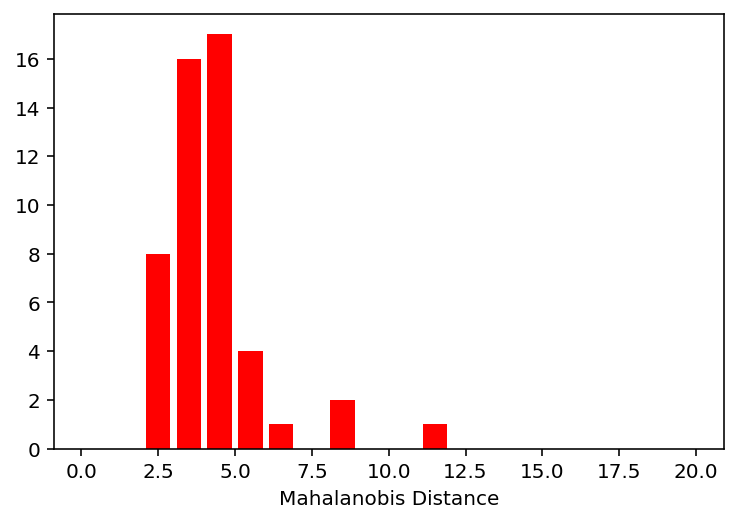

4.566083367381116


In [ ]:
mahaData = []

for file, t in zip(os.listdir(test_out_dir), testData):

   t = t.stack()
   f = os.path.join(test_out_dir, file)  #unit test for correct file extension/null files
   
   maha = Evaluate.Mahalanobis_Distance(f, t, dataset_eval_midi, mEvalData)
   
   mahaData.append(maha[0])



range = (0, 20)
bins = 20

print(mahaData)

plt.hist(mahaData, bins, range, color = 'red', histtype = 'bar', rwidth = 0.8)

plt.xlabel('Mahalanobis Distance')


plt.show()

mahaData = np.mean(mahaData)

print(mahaData)



In [21]:
from collections import Counter

b = music21.converter.parse(r"D:\Github\HonoursProject-reharmonisationGAN\trst.mid")

def Beat_Harmonised_Check(trk: stream):

    chords = trk.chordify()

    t = trk.asTimespans(classList=(note.Note,), flatten=True)

    i = 0
    harmonised = 0
    notHarmonised = 0

    for v in t.iterateVerticalities():

        if v.offset.is_integer():

            c = v.startTimespans

            if len(c) > 1:

                harmonised = harmonised + 1
                i = i + 1

            elif len(c) <= 1:

                notHarmonised = notHarmonised + 1
                i = i + 1

            elif len(c) > 4:

                print("Error! Too many notes at beat: %s, for the number of voices: %s" % (v.offset, len(trk.parts)))


            #for i in c:

                #if i is PitchedTimespan:

                

                #print(i)

            
            #print(c)

        #c = v.startTimespans
        #c = c.toChord()
        #print(c)
        #offSet = ts.offSet
        #v = t.getVerticalityAt(1.0)

        #print(v)

        #v = t.getVerticalityAt(ts)

        #print(v)

        #if c.beat.is_integer() and len(c) > 1:

            #i = i+1
            #harmonised = harmonised + 1

        #elif c.beat.is_integer() and len(c) <= 1:

            #i = i+1
            #notHarmonised = notHarmonised + 1

        #else:
            #continue
    print("Beat Harmonisation Check Results: ")
    print()
    print("Number of beats: %s" % (n_samples*beat_resolution*n_measures))
    print("number of beats to be harmonised: %s" %(i))
    print("Number of beats Harmonised: %s" %(harmonised))
    print("Number of beats not harmonised: %s" %(notHarmonised))
    print()

def Consecutive_intervals(trk: stream):

    sopAlt = stream.Score(id='sopAlt')
    sopTen = stream.Score(id='sopTen')
    sopBass = stream.Score(id='sopBass')
    altTen = stream.Score(id='altTen')
    altBass = stream.Score(id='altBass')
    tenBass = stream.Score(id='tenBass')

    sopAlt.insert(0, trk.parts[0])
    sopAlt.insert(0, trk.parts[1])
    sopTen.insert(0, trk.parts[0])
    sopTen.insert(0, trk.parts[2])
    sopBass.insert(0, trk.parts[0])
    sopBass.insert(0, trk.parts[3])
    altTen.insert(0, trk.parts[1])
    altTen.insert(0, trk.parts[2])
    altBass.insert(0, trk.parts[1])
    altBass.insert(0, trk.parts[3])
    tenBass.insert(0, trk.parts[2])
    tenBass.insert(0, trk.parts[3])

    trackCombos = []

    sA = sopAlt.chordify(addPartIdAsGroup=True)
    sT = sopTen.chordify(addPartIdAsGroup=True)
    sB = sopBass.chordify(addPartIdAsGroup=True)
    aT = altTen.chordify(addPartIdAsGroup=True)
    aB = altBass.chordify(addPartIdAsGroup=True)
    tB = tenBass.chordify(addPartIdAsGroup=True)

    #sB.show()

    trackCombos.append(sA)
    trackCombos.append(sT)
    trackCombos.append(sB)
    trackCombos.append(aT)
    trackCombos.append(aB)
    trackCombos.append(tB)


    parallelFifths = 0
    parallelOctaves = 0

    inv = interval.Interval('P5')
    inv = inv.simpleNiceName

    print("Consecutive Intervals Check Results: ")
    print()
    
    for i in trackCombos:

        pre = str
        chordPrev = chord.Chord()

        for c in i.recurse().notes:

            #print(c.notes)
            

            if len(c) == 2: 
     
                #print(c)
                #print(chordPrev)
 
                intrval = interval.Interval(c.notes[0], c.notes[1]) #c.annotateIntervals(stripSpecifiers=False, returnList=True) 
                intrval = intrval.semiSimpleNiceName

            
                
                if intrval == 'Perfect Fifth' and pre == 'Perfect Fifth':

                    if c.notes[0].nameWithOctave == chordPrev.notes[0].nameWithOctave and c.notes[1].nameWithOctave == chordPrev.notes[1].nameWithOctave:
                        continue

                    else:

                        print("Consecutive fifth found in measure %s" % (c.measureNumber))

                        parallelFifths = parallelFifths + 1
                        pre = intrval
                        chordPrev = c

                if intrval == 'Perfect Octave' and pre == 'Perfect Octave':

                    if c.notes[0].nameWithOctave == chordPrev.notes[0].nameWithOctave and c.notes[1].nameWithOctave == chordPrev.notes[1].nameWithOctave:
                        
                        continue
                    else:

                        print("Consecutive octave found in measure %s" % (c.measureNumber))
                        parallelOctaves = parallelOctaves + 1
                        pre = intrval
                        chordPrev = c

                else:
                    pre = intrval
                    chordPrev = c
    
            elif len(c) > 2:

                print("ERROR! the number of notes at a timestep should not be greater than the number of voices.") # unit test chord greater than 2. also test fifths and octaves at the start/end of pieces
                continue

            elif len(c) < 2:
                continue
        

            #print(intrval)
    print()
    print("Consecutive fifths: %s" % (parallelFifths))
    print("Consecutive octaves: %s" % (parallelOctaves))
    print()

def Voice_Leading(trk: stream): #NEED TO TAKE AVERAGE NUMBER OF INTERVALS FOR ALL BACH PIECES

    z = []

    for semitones in range(14):
        tempInt = interval.Interval(semitones)
        z.append(tempInt.niceName)
        #print(semitones, tempInt.niceName)


    for part in trk:

        intervals = []
        illegalIntervals = ['Diminished Fifth', 'Major Seventh', 'Minor Seventh']

        print()
        print(part.partName)
        print()
        for n in part.flatten().recurse().notes:
            #print(n, n.next())
            intv = interval.Interval(n, n.next())
            intervals.append(intv.niceName)

            for x in illegalIntervals:
                if intv.niceName == x:

                    print("The %s voice contains a '%s' melodic interval!" % (part.partName, x)) #Unit test for chatchin illegal intervals.
                    print()
            #print(intv.niceName)
        l = Counter()
        y = {}
        for i in z:
            l[i] = intervals.count(i)
            
        for key, value in l.items():
            print(key, value)

def Voice_Ranges(trk: stream):

    s = trk.parts[0]
    a = trk.parts[1]
    t = trk.parts[2]
    b = trk.parts[3]

    for n in s.recurse().notes:

        if n.pitch.midi > 81 or n.pitch.midi < 60:

            print("Pitch %s is out of the standard Soprano voice range!" % (n.nameWithOctave))

        else:
            continue
    
    for n in a.recurse().notes:

        if n.pitch.midi > 76 or n.pitch.midi < 55:

            print("Pitch %s is out of the standard Alto voice range!" % (n.nameWithOctave))

        else:
            continue

    for n in t.recurse().notes:


        if n.pitch.midi > 69 or n.pitch.midi < 48:


            print("Pitch %s is out of the standard Tenor voice range!" % (n.nameWithOctave))

        else:
            continue

    
    for n in b.recurse().notes:

        if n.pitch.midi > 64 or n.pitch.midi < 41:

            print("Pitch %s is out of the standard Bass voice range!" % (n.nameWithOctave))

        else:
            continue

        print(n)

def 


        
print()
#Voice_Leading(b)
#Beat_Harmonised_Check(b)
#Consecutive_intervals(b)
Voice_Ranges(b)
#b.show()


In [2]:

b = music21.converter.parse(r"C:\Users\lwgmi\Documents\GitHub\HonoursProject-reharmonisationGAN\midiDataset\test1.mid")

partStream = b.parts.stream()

#for p in partStream:
    #print(p.id)

count = 0

for n in partStream.recurse().notes:
    #print("Note: %s%d %0.1f" % (n.pitch.name, n.pitch.octave, n.duration.quarterLength))

        #notes.append(n)
    count = count+1
    print("Note: %s%s  %s " % (n.pitch.name, n.pitch.octave, n.pitch.midi))
#print(count)
#print(partStream)

#f = note.Note("F5")

#f.show('midi')

def playmidi(filename):
    mf = music21.midi.MidiFile()
    mf.open(filename)
    mf.read()
    mf.close()
    s = music21.midi.translate.midiFileToStream(mf)
    s.show('midi')

#playmidi(r"C:\Users\lwgmi\Documents\GitHub\HonoursProject-reharmonisationGAN\midiDataset\test1.mid")

#b.show()
    

FileNotFoundError: Cannot find file in C:\Users\lwgmi\Documents\GitHub\HonoursProject-reharmonisationGAN\midiDataset\test1.mid

C:\Users\lwgmi\anaconda3\envs\proj_env\Lib\site-packages\music21\corpus\bach\bwv1.6.mxl
Multitrack(name=None, resolution=24, tempo=array(shape=(1920, 1), dtype=float64), downbeat=array(shape=(1920, 1), dtype=bool), tracks=[StandardTrack(name='Horn 2', program=0, is_drum=False, pianoroll=array(shape=(1920, 128), dtype=uint8)), StandardTrack(name='Soprano', program=0, is_drum=False, pianoroll=array(shape=(1920, 128), dtype=uint8)), StandardTrack(name='Alto', program=0, is_drum=False, pianoroll=array(shape=(1920, 128), dtype=uint8)), StandardTrack(name='Tenor', program=0, is_drum=False, pianoroll=array(shape=(1920, 128), dtype=uint8)), StandardTrack(name='Bass', program=0, is_drum=False, pianoroll=array(shape=(1920, 128), dtype=uint8))])


[<AxesSubplot:xlabel='time (beat)', ylabel='Horn 2\n\npitch'>,
 <AxesSubplot:xlabel='time (beat)', ylabel='Soprano\n\npitch'>,
 <AxesSubplot:xlabel='time (beat)', ylabel='Alto\n\npitch'>,
 <AxesSubplot:xlabel='time (beat)', ylabel='Tenor\n\npitch'>,
 <AxesSubplot:xlabel='time (beat)', ylabel='Bass\n\npitch'>]

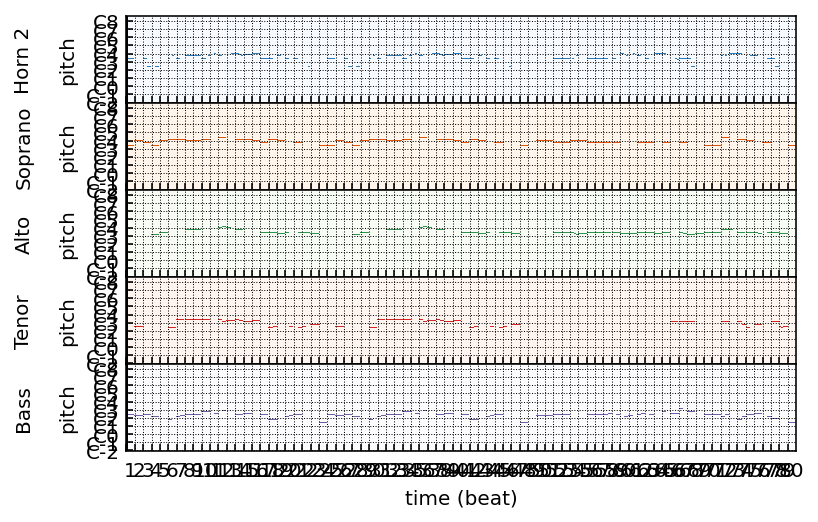

In [137]:
paths = corpus.getComposer('bach')

print(paths[0])

t = music21.converter.parse(paths[0])

trk = t.write('midi', fp=r'C:\Users\lwgmi\Documents\GitHub\HonoursProject-reharmonisationGAN\midiDataset\midi.mid')

trkk = pypianoroll.read(r'C:\Users\lwgmi\Documents\GitHub\HonoursProject-reharmonisationGAN\midiDataset\midi.mid')

print(trkk)

trkk.plot()

In [104]:
m = music21.converter.parse(r'C:\Users\lwgmi\Documents\GitHub\HonoursProject-reharmonisationGAN\Dataset\eval\revmidi\MIDI-Unprocessed_01_R1_2009_01-04_ORIG_MID--AUDIO_01_R1_2009_01_R1_2009_01_WAV.midi')

t = m.asTimespans(classList=(note.Note,), flatten=True)

for v in t.iterateVerticalities():

    c = v.startTimespans

    if len(c) > 1:

        print("woohoo")

    elif len(c) <= 1:

        print("boo")

    




boo
boo
boo
boo
boo
woohoo
boo
boo
boo
woohoo
boo
boo
boo
boo
boo
woohoo
boo
woohoo
boo
boo
boo
boo
boo
boo
boo
boo
boo
boo
boo
boo
woohoo
woohoo
boo
boo
woohoo
woohoo
boo
woohoo
boo
boo
woohoo
boo
boo
boo
boo
boo
boo
woohoo
boo
boo
boo
boo
boo
boo
boo
boo
boo
boo
boo
boo
boo
boo
boo
boo
boo
boo
boo
boo
boo
woohoo
boo
boo
boo
woohoo
boo
boo
boo
woohoo
boo
woohoo
boo
boo
boo
boo
boo
boo
boo
boo
boo
boo
boo
boo
boo
boo
boo
boo
boo
boo
boo
boo
boo
woohoo
boo
boo
boo
boo
boo
boo
boo
boo
boo
boo
woohoo
boo
boo
boo
boo
boo
boo
boo
boo
boo
boo
woohoo
boo
boo
boo
boo
boo
woohoo
woohoo
boo
woohoo
boo
boo
boo
boo
boo
woohoo
boo
woohoo
boo
boo
woohoo
boo
boo
boo
boo
boo
boo
boo
boo
boo
boo
boo
boo
woohoo
boo
boo
boo
boo
boo
boo
boo
boo
boo
boo
boo
boo
woohoo
boo
boo
boo
boo
boo
boo
boo
boo
boo
boo
boo
boo
boo
woohoo
boo
boo
boo
boo
boo
boo
boo
boo
boo
woohoo
boo
woohoo
boo
boo
boo
woohoo
boo
woohoo
boo
boo
boo
boo
boo
woohoo
boo
woohoo
woohoo
boo
boo
boo
boo
boo
boo
woohoo
boo
boo
boo
boo
boo
boo